# Transformer Models for Crypto Forecasting

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW
import math
from tqdm import tqdm

## The Model

### Causal Convolution Layer

In [2]:
class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 embed_dim,
                 kernel_size,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels=1,
            out_channels=embed_dim,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            groups=1,
            bias=bias)
        
        self.__padding = kernel_size - 1
    
    """
    - Output has indices [batch, seqlen, features]
    """
    def forward(self, input):
        padded = F.pad(input.unsqueeze(1), (self.__padding, 0))
        return torch.tanh(super(CausalConv1d, self).forward(padded)).permute(0, 2, 1)

In [3]:
ins = torch.ones((5, 12))

layer = CausalConv1d(3, 5)

print(layer(ins).shape) #[batch, seqlen, feature]

torch.Size([5, 12, 3])


### The Transformer

In [4]:
class TimeFormer(torch.nn.Module): 
    def __init__(self, 
                 d_in, 
                 d_model, 
                 max_seqlen,
                 num_heads, 
                 dropout=0.1): 
        super(TimeFormer, self).__init__()
        
        self.d_in = d_in
        self.num_heads = num_heads
        
        self.conv_embed = CausalConv1d(embed_dim=d_in, kernel_size=9)
        self.positional_embed = nn.Embedding(max_seqlen, d_in)
        
        encoder_layer = nn.TransformerEncoderLayer(d_in, 
                                                        nhead=8, 
                                                        dim_feedforward=d_model, 
                                                        activation='gelu', 
                                                        batch_first=True
                                                       )
        norm1 = nn.LayerNorm(d_in)
        self.decoder = nn.TransformerEncoder(encoder_layer, num_layers=2, norm=norm1)
                
        self.dense = nn.Linear(d_in, 1)
        
        
        
    """
    - x has indices [batch, seqlen]
    """
    def forward(self, x): 
        batch_size, seqlen = x.size()
        
        mask = torch.tril(torch.ones((seqlen, seqlen)), 
                          diagonal=1)
        
        conv_embedding = self.conv_embed(x)
        pos_embedding = self.positional_embed(torch.arange(seqlen))
        
        input_embedding = conv_embedding + pos_embedding 
        
        attn_out = self.decoder(input_embedding, mask)
                
        outputs = self.dense(attn_out)
        
        return torch.squeeze(outputs, dim=2)
    
    """
    Greedy decoding
    
    - x has indices [batch, seqlen]
    """
    def batch_generate(self, x, new_time_steps):         
        seq = x 
        
        for _ in range(new_time_steps): 
            outs = self.forward(seq)
            
            seq = torch.cat((seq, outs[:, -1:]), dim=1)
        
        return seq 
            
            

## Making sure there are no bugs...

In [5]:
ins = torch.rand((3, 10))

model = TimeFormer(d_in = 16, 
                   d_model = 32, 
                   max_seqlen = 256, 
                   num_heads = 4, 
                  )

out = model.forward(ins)
print("out shape: ", out.shape)
print(out)

out shape:  torch.Size([3, 10])
tensor([[ 0.6089, -0.0602,  0.1551,  0.7145, -1.0586,  0.2078, -0.0894, -0.3361,
          0.6570, -1.0839],
        [ 0.6701,  0.0822,  0.4183,  0.8206, -1.1137,  0.1359, -0.2136, -0.5074,
          0.5837, -1.2183],
        [ 0.6106, -0.1301,  0.3317,  0.8465, -1.0684,  0.1058, -0.1892, -0.6451,
          0.7007, -1.1216]], grad_fn=<SqueezeBackward1>)


In [6]:
model = TimeFormer(d_in = 16, 
                   d_model = 32, 
                   max_seqlen = 256, 
                   num_heads = 4, 
                  )
ins = torch.rand((3, 10))

model.batch_generate(ins, 5)

tensor([[ 0.2335,  0.2205,  0.4906,  0.5486,  0.6387,  0.4194,  0.7859,  0.8274,
          0.8982,  0.2220, -0.6529, -0.6346, -0.7720, -0.8705, -0.4201],
        [ 0.2869,  0.8943,  0.5461,  0.9203,  0.4227,  0.7614,  0.4048,  0.5014,
          0.3413,  0.3829, -0.8565, -0.6668, -0.3645, -0.9641, -0.4325],
        [ 0.3246,  0.0993,  0.1504,  0.8909,  0.5992,  0.6593,  0.2948,  0.7414,
          0.2566,  0.2540, -0.1729, -0.6319, -0.5337, -0.9636, -0.2657]],
       grad_fn=<CatBackward0>)

## Data Preprocessing

# Training on synthetic data
To make sure there are no bugs in our code, we'll train our TimeFormer model on a very simple synthetic dataset consisting of two time series: a sine wave and a quadratic function

In [7]:
sinewave = torch.sin(torch.linspace(0, 8*math.pi, 256))
sinewave1 = torch.sin(2*torch.linspace(1, 20, 256)+1)
quadratic = torch.linspace(0, 4, 256) ** 2

tnsr = torch.stack((sinewave, sinewave1, quadratic))
print(tnsr)
miniset = TensorDataset(tnsr)

tensor([[ 0.0000e+00,  9.8400e-02,  1.9585e-01,  2.9139e-01,  3.8411e-01,
          4.7309e-01,  5.5749e-01,  6.3647e-01,  7.0928e-01,  7.7520e-01,
          8.3360e-01,  8.8391e-01,  9.2564e-01,  9.5838e-01,  9.8182e-01,
          9.9573e-01,  9.9998e-01,  9.9452e-01,  9.7941e-01,  9.5479e-01,
          9.2091e-01,  8.7808e-01,  8.2673e-01,  7.6736e-01,  7.0054e-01,
          6.2692e-01,  5.4722e-01,  4.6220e-01,  3.7270e-01,  2.7958e-01,
          1.8375e-01,  8.6133e-02, -1.2320e-02, -1.1065e-01, -2.0791e-01,
         -3.0315e-01, -3.9545e-01, -4.8391e-01, -5.6767e-01, -6.4593e-01,
         -7.1791e-01, -7.8293e-01, -8.4034e-01, -8.8960e-01, -9.3023e-01,
         -9.6183e-01, -9.8409e-01, -9.9680e-01, -9.9983e-01, -9.9316e-01,
         -9.7685e-01, -9.5106e-01, -9.1603e-01, -8.7212e-01, -8.1974e-01,
         -7.5940e-01, -6.9170e-01, -6.1728e-01, -5.3687e-01, -4.5124e-01,
         -3.6124e-01, -2.6773e-01, -1.7163e-01, -7.3852e-02,  2.4638e-02,
          1.2289e-01,  2.1995e-01,  3.

We use the AdamW optimizer and a straightforward MSE loss. 

In [8]:
minimodel = TimeFormer(d_in = 64, 
                   d_model = 256, 
                   max_seqlen = 256, 
                   num_heads = 4, 
                  )

lr = 3e-4
optimizer = AdamW(minimodel.parameters(), lr=lr)

loss_fn = nn.MSELoss()

100%|█████████████████████████████████████| 10000/10000 [06:30<00:00, 25.62it/s]


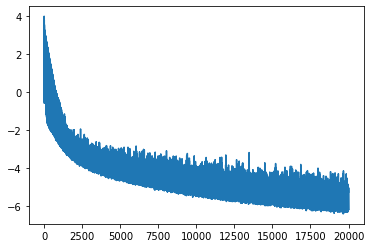

In [9]:
num_epochs = 10000

miniloader = DataLoader(miniset, batch_size=2)

log_losses = []
for i in tqdm(range(num_epochs)): 
    for _, batch in enumerate(miniloader):
        optimizer.zero_grad()
        
        batch = batch[0]
        outs = minimodel.forward(batch)
        
        target = batch[:, 1:]
        predictions = outs[:, :-1]
        
        loss = loss_fn(target, predictions)
        
        loss.backward()
        optimizer.step()
        log_losses.append(math.log(loss.item()))
        
plt.plot(log_losses)

tensor([[ 0.0000,  0.0984,  0.1958,  0.2914,  0.3841,  0.4731,  0.5575,  0.6365,
          0.7093,  0.7752,  0.8336,  0.8839,  0.9256,  0.9584,  0.9818,  0.9957,
          1.0000,  0.9945,  0.9794,  0.9548,  0.9209,  0.8781,  0.8267,  0.7674,
          0.7005,  0.6269,  0.5472,  0.4622,  0.3727,  0.2796,  0.1837,  0.0861,
         -0.0123, -0.1107, -0.2079, -0.3032, -0.3955, -0.4839, -0.5677, -0.6459,
         -0.7179, -0.7829, -0.8403, -0.8896, -0.9302, -0.9618, -0.9841, -0.9968,
         -0.9998, -0.9932, -0.9768, -0.9511, -0.9160, -0.8721, -0.8197, -0.7594,
         -0.6917, -0.6173, -0.5369, -0.4512, -0.3612, -0.2677, -0.1716, -0.0739,
          0.0246,  0.1229,  0.2199,  0.3149,  0.4067,  0.4947,  0.5778,  0.6553,
          0.7264,  0.7905,  0.8470,  0.8952,  0.9347,  0.9651,  0.9862,  0.9977,
          0.9995,  0.9916,  0.9741,  0.9472,  0.9110,  0.8660,  0.8126,  0.7513,
          0.6827,  0.6075,  0.5264,  0.4402,  0.3497,  0.2558,  0.1595,  0.0616,
         -0.0370, -0.1351, -

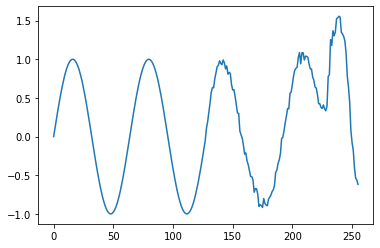

In [10]:
test = sinewave[:128].unsqueeze(dim=0)

with torch.no_grad(): 
    completion = minimodel.batch_generate(test, 128)

print(completion)
plt.plot(completion[0])
plt.show()